# About this notebook 

Investigate the k-core profile of the Pokec network. [What is the k-core?](https://en.wikipedia.org/wiki/Degeneracy_(graph_theory))

In [ ]:
import numpy as np 
from scipy import sparse 
import pandas as pd 

Load the Pokec network 


In [ ]:
dfe = pd.read_csv("https://snap.stanford.edu/data/soc-pokec-relationships.txt.gz", sep="\t", names=["source", "target"], nrows=None)
dfe = dfe.astype({'source': 'int', 'target': 'int'})
dfe = dfe.drop_duplicates()
dfe = dfe[dfe.source != dfe.target] - 1

In [ ]:
dfe.head()

In [ ]:
def kcore_decomposition(A):
    """k-core decomposition

    :param A: Adjacency matrix 
    :type A: sparse.csr_matrix 
    :return: list of nodes in k-cores. The keys and values of the dict are the value of "k" (degree threshold) and the numpy array of node ids in a k-core.  
    :rtype: dict
    """

    # To ensure that the network is symmetric and unweighted
    A = A + A.T 
    A.data = A.data * 0 + 1

    kth = 1 # Threshold for the degree
    net = A.copy()
    node_ids = np.arange(net.shape[0])
    kcore_node_list = {}
    while len(node_ids)>1:
        while True:
            deg = np.array(net.sum(axis = 0)).reshape(-1) 
            is_in_kcore = deg >= kth

            # If everyone is in the k-core, break
            if np.all(is_in_kcore):
                break

            # Otherwise remove non-k-core nodes. 
            net = net[is_in_kcore, :][:, is_in_kcore]
            node_ids = node_ids[is_in_kcore]

        kcore_node_list[kth] = node_ids.copy()
        kth+=1
    return kcore_node_list 

k-core decomposition 

In [ ]:
n = dfe[["source", "target"]].values.max() + 1
net = sparse.csr_matrix((np.ones(dfe.shape[0]), (dfe["source"], dfe["target"])), shape=(n, n))

In [25]:
kcore = kcore_decomposition(net)

Plot results

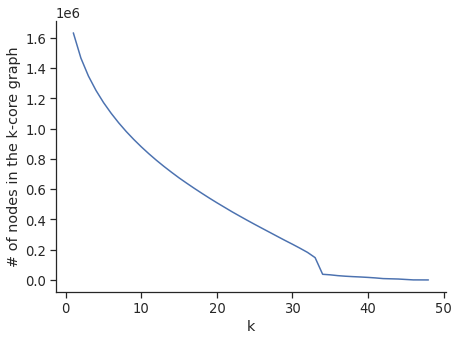

In [30]:
# Calculate the size of k-core graphs
plot_data = pd.DataFrame([{"size": len(v), "k":k} for k, v in kcore.items()])

import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set_style('white')
sns.set(font_scale=1.2)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(7,5))

sns.lineplot(data = plot_data, x = "k", y = "size")
ax.set_xlabel("k")
ax.set_ylabel("# of nodes in the k-core graph")
sns.despine()
#ax.set_yscale("log")

# Save results 

In [43]:
data = {str(int(k)):list(map(str, nodes)) for k, nodes in kcore.items()}

import json 
with open("kcore.json", "w") as f: 
    json.dump(data, f)